In [1]:
import os
import sys
import json
from pathlib import Path
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../../external/BoostTrack'))
sys.path.append(os.path.abspath('../../external/BoostTrack/external'))
# sys.path.append(os.path.abspath('../../fast-reid'))
# sys.path.append(os.path.abspath('../../fast_reid'))

# ----------- local imports ----------- 
from utils import show_images, get_frame, get_frame_test, get_info_from_seqinfo
from constants import TRAIN_PATH, TEST_PATH, MODEL_DIR
from dataset import df_train, get_vid_img_path, get_vid_gt_path
from FasterRcnn.inference import *

In [2]:
from PIL import Image
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torchvision
import cv2


In [3]:
from tracker.boost_track import BoostTrack

/home/aliaagheis/miniconda3/envs/fast_env/lib/python3.12/site-packages/torchreid/reid/metrics/rank.py:11: UserWarning: Cython evaluation (very fast so highly recommended) is unavailable, now use python evaluation.
  warnings.warn(
2025-03-20 10:35:51.421179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-20 10:35:51.436764: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-20 10:35:51.441276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-20 10:35:51.457636: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = [get_frame("02", 1), get_frame("02", 2)]

# load model
model  = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT).to(device)
checkpoint = torch.load(MODEL_DIR /"fastercnn_batch16_epoch2_step1875.pth.tar")
model.load_state_dict(checkpoint['model_state_dict'])

# inference
detections = inference(model, images, device)
detections_ = [torch.cat([d['boxes'], d['scores'].unsqueeze(1)], dim=1) for d in detections]

/tmp/ipykernel_61650/3938296077.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_DIR /"fastercnn_batch16_epoch2_step1875.pth.tar")


In [6]:
tracker = BoostTrack()
# tracker.ecc.cache.clear()

In [7]:
img_numpy = np.array(images[0]) # C x H x W
img_tensor = torch.tensor(img_numpy) # B x C x H x W

result1 = tracker.update(detections_[0], img_tensor, img_numpy, "MOT20-02")

/home/aliaagheis/projects/Fawary-Competition-surveillance-for-retail-stores-/external/BoostTrack/tracker/embedding.py:195: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd =

In [8]:
img_numpy = np.array(images[1]) # C x H x W
img_tensor = torch.tensor(img_numpy) # B x C x H x W
result2 = tracker.update(detections_[1], img_tensor, img_numpy, "MOT20-02")

RuntimeError: ERROR: The number of cached embeddings don't match the number of detections.
Was the detector model changed? Delete cache if so.

In [28]:
len(result1)

33

In [26]:
len(detections_[0]), len(detections_[1])

(100, 100)

In [9]:
def draw_boosttrack_result(result, image):
    image_np = np.array(image)
    
    bboxs = result[:,:4]
    ids = result[:,4]
    scores = result[:,5]
    
    # Draw bounding boxes
    for score, id_, box in zip(scores, ids, bboxs):
        label_text = f"#{id_}: {round(score.item(), 2)}"
        # if score < 0.5: continue
            
        box = [round(i, 2) for i in box.tolist()]
        x1, y1, x2, y2 = map(int, box)
        
        cv2.rectangle(image_np, (x1, y1), (x2, y2), (0, 255, 0), 2)        
        text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
        text_x, text_y = x1, y1 - 5
        cv2.rectangle(image_np, (text_x, text_y - text_size[1] - 3), (text_x + text_size[0] + 3, text_y), (0, 255, 0), -1)
        cv2.putText(image_np, label_text, (text_x, text_y - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))

    return Image.fromarray(image_np)

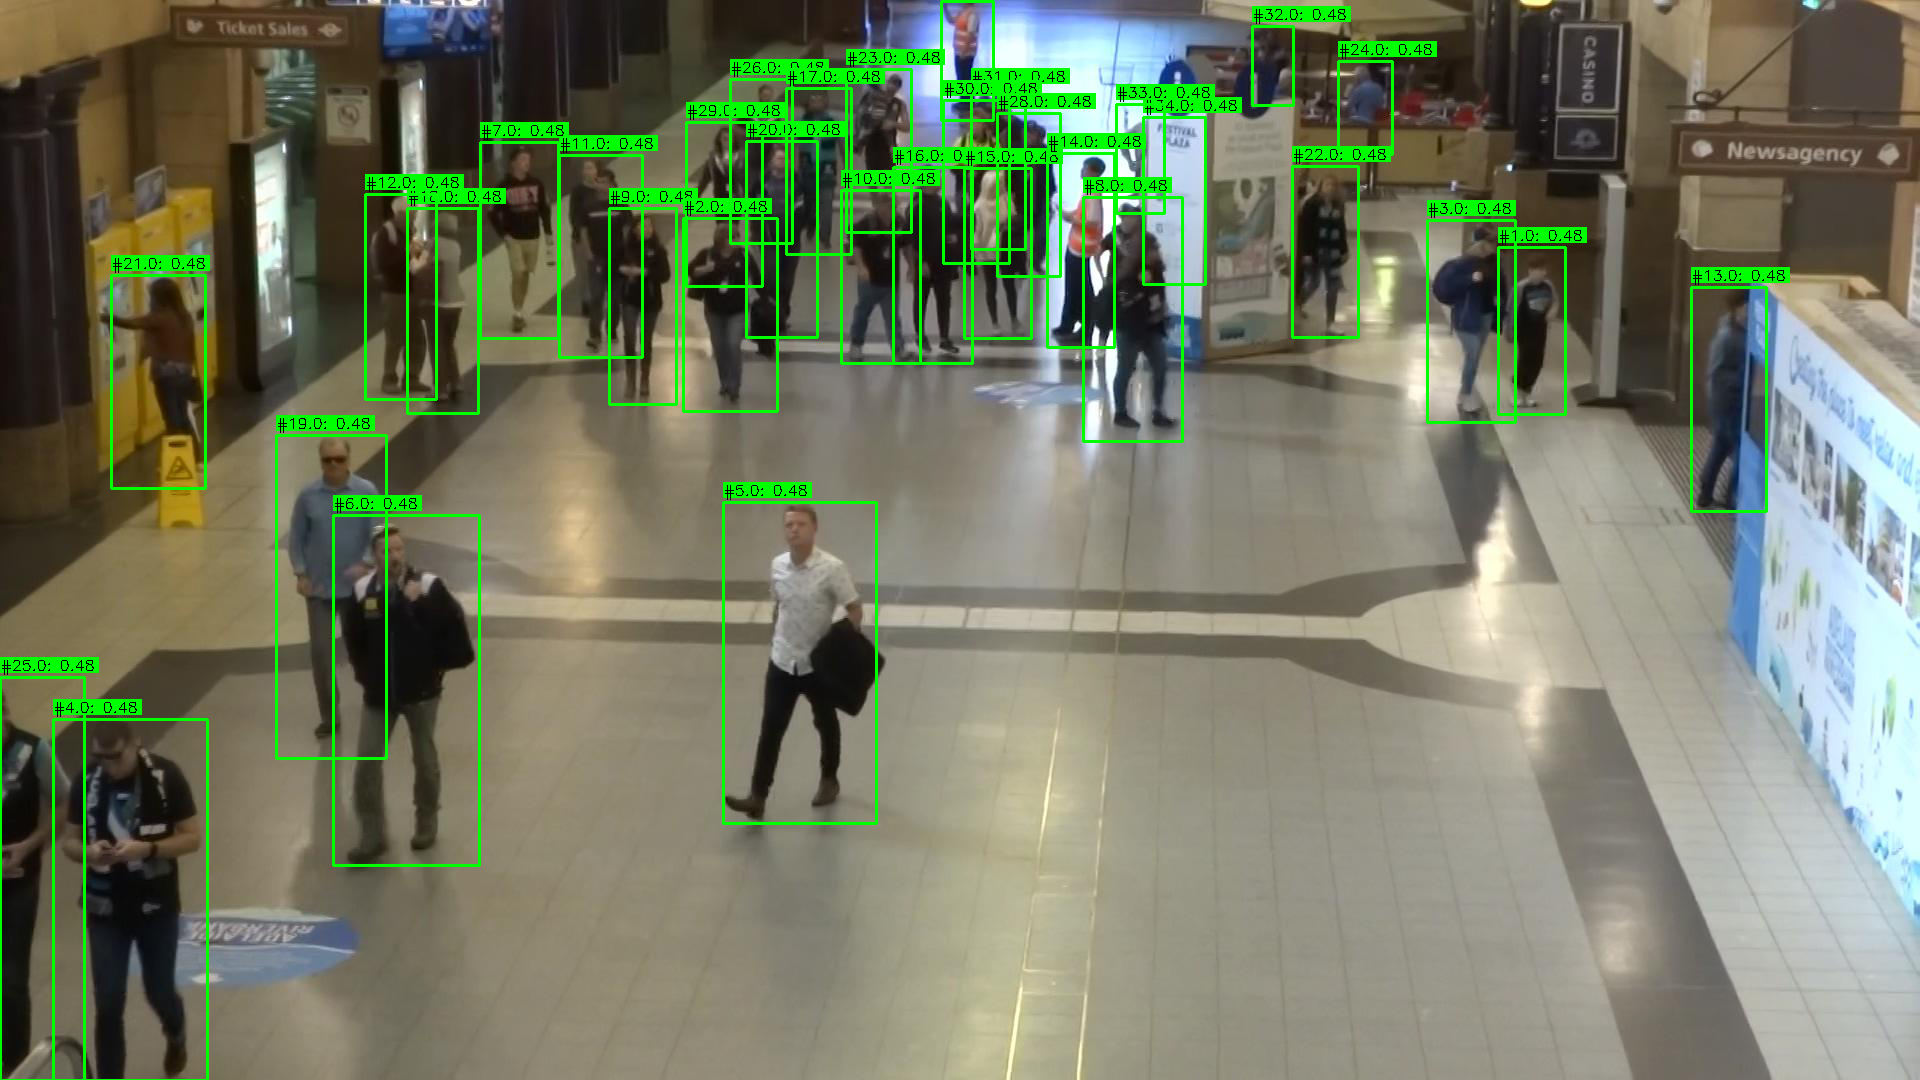

In [10]:
draw_boosttrack_result(result1, images[0])